In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### В качестве исходных данных был выбран датасет, содержащий информацию о графическом изображении букв латинского алфавита. Информация выражена в ряде определенных коэффициентов (16 параметров), отвечающих за наклон, размер и т. д. Задачей классификации является установление по данным числовым характеристикам символ, за который они отвечают. Выборка содержит 20 000 строк с различными вариантами написания символов A-Z с использованием различных шрифтов. Числовые параметры каждого символа содержатся в 16 столбцах исходной таблицы.

In [58]:
column_names = ['lettr','x-box','y-box','width','high','onpix','x-bar',
                'y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
df = pd.read_csv('letter-recognition.data', sep=',', names = column_names)
Y = df['lettr']
X = df.drop(columns = 'lettr')
x_train, x_test, y_train, y_test = train_test_split(X ,Y, test_size = 0.25, random_state = 1)
df.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [42]:
native_dataset_model = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 200)
native_dataset_model.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [43]:
native_dataset_model_predict = native_dataset_model.predict(x_test)
print("Precision =",precision_score(y_test, native_dataset_model_predict, average='macro'))
print("Recall =",recall_score(y_test, native_dataset_model_predict, average='macro'))
print("Accuracy =",accuracy_score(y_test, native_dataset_model_predict))

Precision = 0.9417789977293942
Recall = 0.941377934702638
Accuracy = 0.9416


### Далее проведем процедуру преобразования данных
#### Для начала оценим важность критериев

In [44]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.02496082 0.02458516 0.02279364 0.02217656 0.02921743 0.05351289
 0.07214493 0.09011173 0.09667999 0.07239216 0.07694777 0.08792114
 0.1051354  0.07552132 0.09137715 0.05452191]


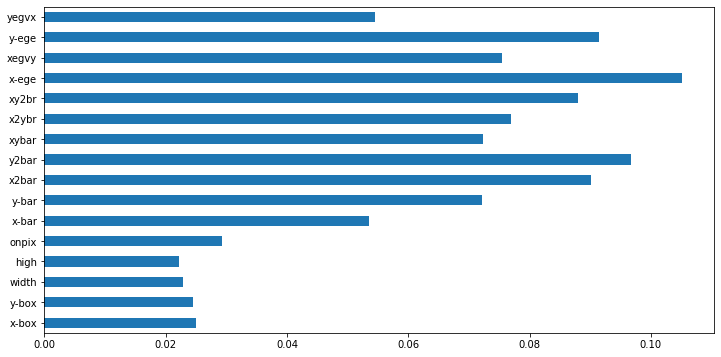

In [45]:
model = ExtraTreesClassifier()
model.fit(x_train, y_train)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(12,6))
feat_importances.plot(kind='barh')
plt.show()

In [46]:
(np.array(model.feature_importances_)>0.04).sum()

11

### Сформируем новую выборку, отобрав 11 лучших признаков (значимость выше 0.04)

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

In [48]:
selector = SelectKBest(f_classif, k=5)

In [49]:
selector.fit(x_train, y_train)
selector.get_support()

array([False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True,  True, False, False])

In [50]:
x_train_new = pd.DataFrame(selector.transform(x_train))
x_test_new = pd.DataFrame(selector.transform(x_test))

In [51]:
select_dataset_model = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 200)
select_dataset_model.fit(x_train_new, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [52]:
select_dataset_model_predict = select_dataset_model.predict(x_test_new)
print("Precision =",precision_score(y_test, select_dataset_model_predict, average='macro'))
print("Recall =",recall_score(y_test, select_dataset_model_predict, average='macro'))
print("Accuracy =",accuracy_score(y_test, select_dataset_model_predict))

Precision = 0.6731898002733515
Recall = 0.6741517343696504
Accuracy = 0.6722


### Из результатов работы модели видно, что точность предсказания значительно снизилась. Несмотря на уменшение исходной выборки на 5 столбцев и увеличение скорости обучения модели, данные преимущества не оправдывают столь большего снижения точности

### Далее попробуем сформировать из уже имеющихся признаков другие признаки, которые могут оказаться более удачными для работы с данными

In [59]:
X.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [60]:
X['S'] = X.apply(lambda row: row['width']*row['high'], axis = 1)
#X.drop(columns=['width', 'high'])
X.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,S
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8,15
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10,21
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9,48
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8,36
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10,3


In [61]:
x_train, x_test, y_train, y_test = train_test_split(X ,Y, test_size = 0.25, random_state = 1)

In [62]:
S_dataset_model = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 200)
S_dataset_model.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [63]:
S_dataset_model_predict = S_dataset_model.predict(x_test)
print("Precision =",precision_score(y_test, S_dataset_model_predict, average='macro'))
print("Recall =",recall_score(y_test, S_dataset_model_predict, average='macro'))
print("Accuracy =",accuracy_score(y_test, S_dataset_model_predict))

Precision = 0.9425345592653542
Recall = 0.9422210056895354
Accuracy = 0.9422


### Добавление нового признака увеличило точность модели на 0.1% что является неплохим результатом для довольно простого перемножения двух чисел (получение площади изображения из высоты и ширины)
#### При это оба исходных признака были оставлены в наборе данных, т.к. их удаление немного снизит точность (почти вся информация хранится в площади, но некоторая ее часть теряется)
#### Для увеличения скорости работы можно заменить два признака width и hegh  на их произведение почти без потери точности.

### Попробуем применить процедуру нормализации данных, т.к. все они приведены в разных шкалах и величинах 

In [64]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

#### ВАЖНО что тестовые данны нормализуются с параметрами обучающих, чтобы не допустить "утечки" информации

In [65]:
x_train.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,S
18960,-1.057060,-0.618520,-0.551574,-0.607129,-0.228938,1.035015,-0.216080,-0.971156,0.348695,1.087047,-0.549739,-0.450873,0.407433,-0.868156,0.511053,0.734095,-0.726618
11353,0.511330,-0.315036,-0.056059,-0.607129,0.226812,-2.405750,1.508877,-0.971156,-0.912864,0.686769,1.347657,0.030829,0.833855,1.717308,-1.041591,-0.496988,-0.526166
7449,-1.057060,-0.922004,-1.542604,-1.048014,-1.140439,0.051939,1.508877,-0.971156,0.348695,-0.514063,1.727137,0.030829,-0.871836,1.717308,-1.041591,-0.496988,-1.227748
14308,-1.579857,-2.135940,-2.038119,-2.370670,-1.596189,-1.422674,-0.647319,0.135504,-1.333383,-0.514063,-0.170260,1.475935,-0.445413,-0.221790,-0.653430,1.349636,-1.528425
11889,2.602517,1.809350,1.430485,0.715528,0.226812,0.051939,-0.216080,-0.602269,0.769214,0.286492,0.968178,0.512531,1.260278,1.717308,-0.265269,-0.496988,1.277901


In [66]:
Sn_dataset_model = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 200)
Sn_dataset_model.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [67]:
Sn_dataset_model_predict = Sn_dataset_model.predict(x_test)
print("Precision =",precision_score(y_test, Sn_dataset_model_predict, average='macro'))
print("Recall =",recall_score(y_test, Sn_dataset_model_predict, average='macro'))
print("Accuracy =",accuracy_score(y_test, Sn_dataset_model_predict))

Precision = 0.9426575943499783
Recall = 0.9424023321619543
Accuracy = 0.9426


### Видно, что точность возрасла, но совершенно несущественоо (0.01%) т.к. данные модели не так критично ошибаются при работе с не нормированными данными